# Library

In [1]:
import pandas as pd
from bertopic import BERTopic

c:\Users\dommy\miniconda3\envs\gestione\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2 Baseline Summary

## Clustering Approach

- **Parameter Setting**:
  - Embedding Model: all-MiniLM-L6-v2
  - Representation Model: keyBERTInspired, MaximalMarginalRelevance
  - Count Vectorizer
  - CtfIDF
  - UMAP: 20 neighbors, 10 components
  - HDBSCAN: 150 min cluster size
  - Zero-Shot Classification on cluster name
  - Outliers-reduction with Cosine Similarity: 0.46 threshold

## Clustering Results

- **Clusters Retrieved**: 68 in which the most important ones concern:
  1. Drug sales (marijuana, cocaine, xanax, pills, meth, fentanyl)
  2. Bitcoin
  3. Scammers and seller reviews
  4. Marketplace advertising
  5. Purchase reviews
  6. Drug purchases
  7. Orders
  8. Closed sites (empire market, 
  9. Scams
  10. Sold passwords
  11. Hacker attacks
  12. Opsec questions
  13. Document and credit card forgery
  14. Chat links

- **Performance Metrics**:
  - **Silhouette Score**: 0.50
  - **Davies-Bouldin Score**: 0.87
  - **Coherence-Score**: 0.57
  - **Dos Score**: 0.06
  - **%Outliers**: 0.30 (19k/65k)

# Code

In order to avoid importing the whole **BERTopicUtils.py** module, and thus the linked libraries, I have only brought back the function needed to make predictions, it is the same as in the module

In [2]:
def predict_topic(topic_model: BERTopic, sentence: list, num_classes: int = 5, custom_labels: bool = False) -> pd.DataFrame:
    """
    Predict the topic of a sentence using the BERTopic model.
    :param topic_model: The BERTopic model.
    :param sentence: The sentence to predict the topic of.
    :param num_classes: The number of classes to return.
    :param custom_labels: Whether to use custom labels.
    :return: A DataFrame with the predicted topics.
    """
    # Transform the sentence
    _, pr = topic_model.transform(sentence)

    # Get the top indices
    top_indices = np.argsort(pr[0])[::-1][:num_classes]

    # Get the top topics
    if custom_labels:
        top_topics = [(topic_model.get_topic(i), pr[0][i], topic_model.custom_labels_[i+1]) for i in top_indices]
    else:
        top_topics = [(topic_model.get_topic(i), pr[0][i], topic_model.generate_topic_labels()[i+1]) for i in top_indices]
    
    # Create a DataFrame with the results
    df_finals = pd.DataFrame(top_topics, columns=['Topic', 'Probability', 'Label'])

    # Extract the words and sentence
    df_finals['Words'] = df_finals['Topic'].apply(lambda topic: [word for word, _ in topic])

    df_finals['Sentence'] = sentence * len(df_finals)
    
    return df_finals

In [14]:
df = pd.read_parquet('CSV68Topic/BERTopic_all-MiniLM-L6-v2_150_20n.parquet').rename({'Name': 'BERTopic_Name', 'CustomName': 'Custom_Name_Zero_Shot'}, axis=1)
df.drop(columns='Embedding', inplace=True)
df.head(3)

,Document,Topic,Probability,Created_on,Count,BERTopic_Name,Custom_Name_Zero_Shot,Representation,Representative_Docs
0,naturalmeds apollon,56,"[1.1964202652021368e-307, 6.589650224023648e-3...",2020-01-09,242,56_apollon_apollon market_market_apollon apollon,market - apollon - apollon market,"[apollon, apollon market, market, apollon apol...","[back apollon, apollon, apollon market]"
1,redemption btc giveaway coke sub dread member ...,24,"[0.006596099708564405, 0.003763170646085399, 0...",2020-01-09,544,24_coke_coke vendor_best coke_uk coke,cocaine,"[coke, coke vendor, best coke, uk coke, uk, go...","[fire coke, coke vendor , coke vendor]"
2,flubromazolam sample giveaway,62,"[8.335712654832696e-308, 7.430095287264378e-30...",2019-11-06,290,62_alprazolam_powder_alprazolam powder_flualpr...,powder - alprazolam - alprazolam powder,"[alprazolam, powder, alprazolam powder, flualp...",[usa domestic alprazolam powder mxe apvp inbom...


In [13]:
document_topic = df[['Document', 'Topic', 'Probability', 'Created_on', 'Name']].rename({'Name': 'BERTopic_Name'}, axis=1)
document_topic.to_csv('CSV68Topic/document_topic_proba.csv')

In [19]:
topics_over_time = pd.read_csv('CSV68Topic/topic_over_time_3.csv')
topics_over_time.drop_duplicates('Topic', inplace=True)
topics_over_time

,Topic,Words,Frequency,Timestamp,Custom_Name_GenAI
0,0,"weed, cart, review, cannabis, thc",893,2019-08-05 17:55:40.800,Cannabis Weed Vape Cart Reviews
3,1,"help, sub, need, guy, back",381,2019-08-05 17:55:40.800,Subreddit Help Needed
6,2,"order, shipping, package, pack, delivery",367,2019-08-05 17:55:40.800,USPS Package Delivery
9,3,"empire, empire market, empire empire, market, ...",319,2019-08-05 17:55:40.800,Empire Market Deposit Issues
12,4,"vendor, vendor vendor, new, new vendor, inquiry",577,2019-08-05 17:55:40.800,Trusted Vendor Inquiries
...,...,...,...,...,...
181,63,"dmt, dmt vendor, dmt vape, odsmt, dmt dmt",41,2019-08-05 17:55:40.800,DMT Vendors
183,64,"captcha, rapture, rapture market, apb mapb, mapb",35,2019-08-05 17:55:40.800,Rapture Market Captcha
185,65,"chemical, research, research chemical, bromazo...",26,2019-08-05 17:55:40.800,Research Chemicals
187,66,"tor, tor browser, browser, research, disabled",38,2019-08-05 17:55:40.800,Tor Browser Research


In [22]:
pic2 = df[['Topic', 'Count', 'BERTopic_Name', 'Representation', 'Representative_Docs', 'Custom_Name_Zero_Shot']]
pic2.merge(topics_over_time[['Topic', 'Custom_Name_GenAI']], on='Topic', how='inner')[['Topic', 'Count', 'BERTopic_Name', 'Representation', 'Representative_Docs', 'Custom_Name_GenAI', 'Custom_Name_Zero_Shot']].to_csv('CSV68Topic/description_topic.csv', index=False)

# Visualize CSV Files

In [ ]:
descr_topic = pd.read_csv('CSV68Topic/description_topic.csv')
document_topic = pd.read_csv('CSV68Topic/document_topic_proba.csv')
topics_over_time = pd.read_csv('CSV68Topic/topic_over_time_3.csv')

In [ ]:
fin = descr_topic.merge(topics_over_time[['Topic', 'Custom_Name_GenAI']], how='inner', on='Topic').drop_duplicates(subset='Topic').reset_index(drop=True)
df_zero = pd.read_csv(r'C:\Users\dommy\OneDrive\Documenti\GSoC - Final\GSoC\Analyze_files\CombiningAnalysisCompleteDataset\ThreadAnalysis\ZeroShotClassificationResults\distiluse_7cluster\zero_shot_02.csv')
fin = fin.merge(df_zero, how='inner', left_on='Topic', right_on='Topic').drop_duplicates(subset='Topic').rename({'Labels': 'Custom_Name_Zero_Shot'}, axis=1)
fin

In [ ]:
df = pd.read_parquet('Deliverable7Topic/BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout.parquet')
df.drop(columns=['Embedding', 'UMAP_embedding', 'Count', 'Name', 'Representation', 'Representative_Docs'], inplace=True)
df.to_csv('Deliverable7Topic/document_topic_proba.csv', index=False)

In [ ]:
df_over_time_10 = pd.read_csv(r'C:\Users\dommy\OneDrive\Documenti\GSoC - Final\GSoC\Analyze_files\CombiningAnalysisCompleteDataset\ThreadAnalysis\DatasetsThreadBERTopic\BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout_topics_over_time_10.csv')
df_over_time_3 = pd.read_csv(r'C:\Users\dommy\OneDrive\Documenti\GSoC - Final\GSoC\Analyze_files\CombiningAnalysisCompleteDataset\ThreadAnalysis\DatasetsThreadBERTopic\BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout_topics_over_time_3.csv')
df_over_time_2 = pd.read_csv(r'C:\Users\dommy\OneDrive\Documenti\GSoC - Final\GSoC\Analyze_files\CombiningAnalysisCompleteDataset\ThreadAnalysis\DatasetsThreadBERTopic\BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout_topics_over_time_2.csv')
df_over_time_5 = pd.read_csv(r'C:\Users\dommy\OneDrive\Documenti\GSoC - Final\GSoC\Analyze_files\CombiningAnalysisCompleteDataset\ThreadAnalysis\DatasetsThreadBERTopic\BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout_topics_over_time_5.csv')
df_fin = df_over_time_5.merge(df_over_time_10[['Topic', 'Name']], how='inner', on='Topic').drop_duplicates().reset_index(drop=True)
df_fin.to_csv(r'C:\Users\dommy\OneDrive\Documenti\GSoC - Final\GSoC\Analyze_files\CombiningAnalysisCompleteDataset\ThreadAnalysis\DatasetsThreadBERTopic\BERTopic_nodefinedcluster_topics_15n_10com_1200cluster_0.64sil_renewout_topics_over_time_5.csv', index=False)

In [19]:
topic_model.visualize_barchart(top_n_topics=70, custom_labels=True, n_words=10, width=350, height=350)

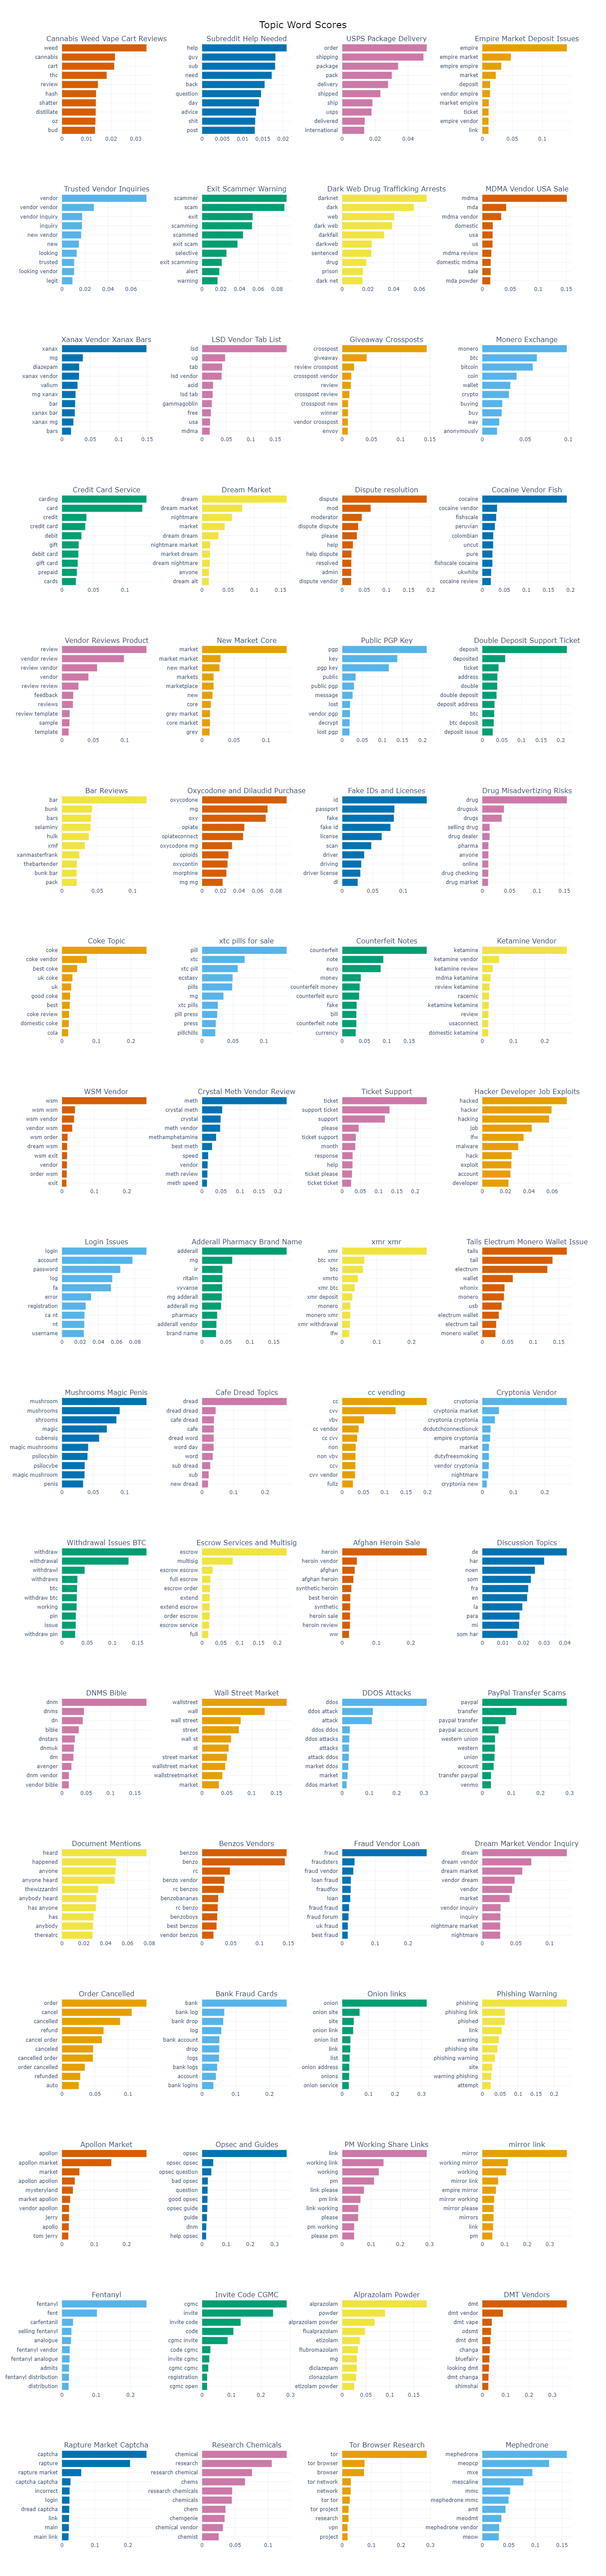

In [24]:
topics_over_time = topic_model.topics_over_time(tc1.corpus, created_on, 
                                                global_tuning=True, evolution_tuning=True, nr_bins=10)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10, width=1250, height=700, custom_labels=True)

7it [00:17,  2.44s/it]


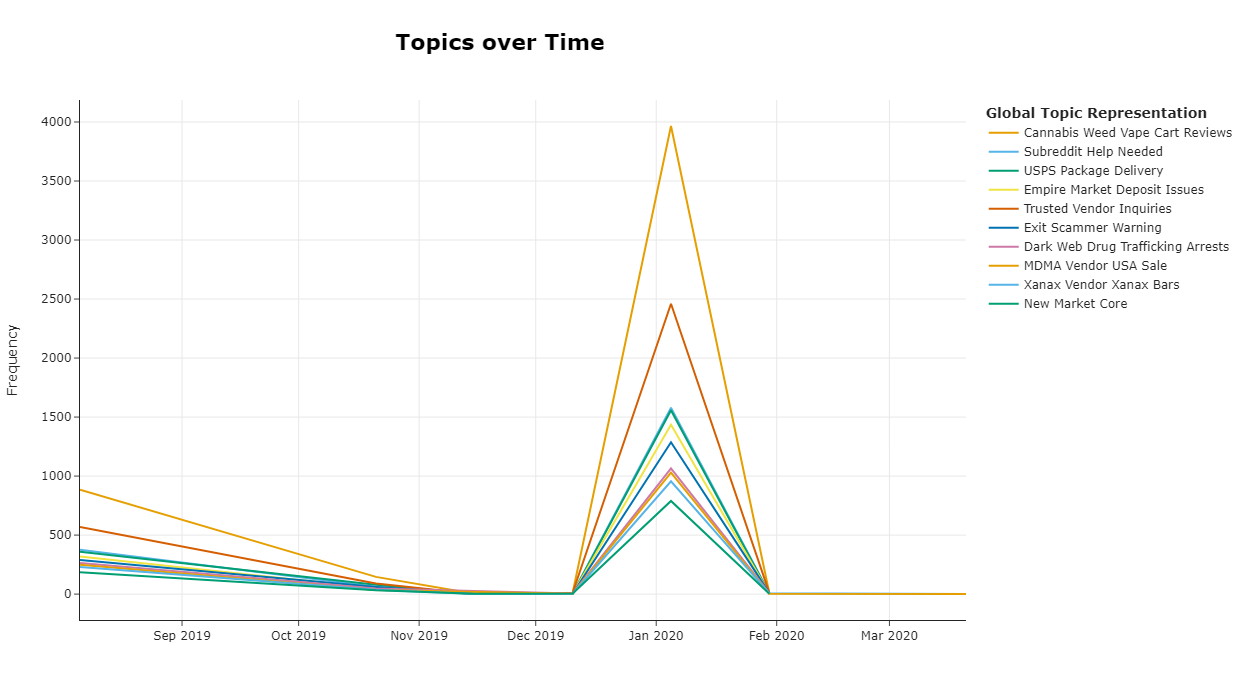

In [32]:
topics_over_time[topics_over_time['Topic'] != -1].sort_values(by=['Topic', 'Timestamp']).to_csv('DatasetsThreadBERTopic/BERTopic_all-MiniLM-L6-v2_150_20n_topics_over_time.csv', index=False)

### Examples

In [21]:
topic_model = BERTopic.load("Models/topic_model_all-MiniLM-L6-v2_150_20n")

In [22]:
sentence = ['recently closed Samsara market']
btu.predict_topic(topic_model, sentence, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 31.88it/s]


,Topic,Probability,Label,Words,Sentence
0,"[(cryptonia, 0.270593329016721), (cryptonia ma...",0.002991,Cryptonia Vendor,"[cryptonia, cryptonia market, cryptonia crypto...",recently closed Samsara market
1,"[(empire, 0.1408905571475779), (empire market,...",0.002262,Empire Market Deposit Issues,"[empire, empire market, empire empire, market,...",recently closed Samsara market
2,"[(wallstreet, 0.17075397467717646), (wall, 0.1...",0.002127,Wall Street Market,"[wallstreet, wall, wall street, street, wall s...",recently closed Samsara market
3,"[(scammer, 0.09029491748260987), (scam, 0.0879...",0.002075,Exit Scammer Warning,"[scammer, scam, exit, scamming, scammed, exit ...",recently closed Samsara market
4,"[(crosspost, 0.14470709618860572), (giveaway, ...",0.002045,Giveaway Crossposts,"[crosspost, giveaway, review crosspost, crossp...",recently closed Samsara market


In [18]:
sentence = ['i want to buy some pgp keys']
btu.predict_topic(topic_model, sentence, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


,Topic,Probability,Label,Words,Sentence
0,"[(pgp, 0.2106338648158133), (key, 0.1374706728...",1.0,Public PGP Key,"[pgp, key, pgp key, public, public pgp, messag...",i want to buy some pgp keys
1,"[(mephedrone, 0.15930437837531358), (meopcp, 0...",0.0,Mephedrone,"[mephedrone, meopcp, mxe, mescaline, mmc, meph...",i want to buy some pgp keys
2,"[(coke, 0.24480516496483845), (coke vendor, 0....",0.0,Coke Topic,"[coke, coke vendor, best coke, uk coke, uk, go...",i want to buy some pgp keys
3,"[(deposit, 0.21545306050516058), (deposited, 0...",0.0,Double Deposit Support Ticket,"[deposit, deposited, ticket, address, double, ...",i want to buy some pgp keys
4,"[(bar, 0.11981212043710264), (bunk, 0.04275809...",0.0,Bar Reviews,"[bar, bunk, bars, selaminy, hulk, xmf, xanmast...",i want to buy some pgp keys


In [8]:
sentence = ['atk hack']
btu.predict_topic(topic_model, sentence, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


,Topic,Probability,Label,Words,Sentence
0,"[(hacked, 0.07268774210946359), (hacker, 0.059...",1.0,Hacker Developer Job Exploits,"[hacked, hacker, hacking, job, lfw, malware, h...",atk hack
1,"[(mephedrone, 0.15930437837531358), (meopcp, 0...",0.0,Mephedrone,"[mephedrone, meopcp, mxe, mescaline, mmc, meph...",atk hack
2,"[(coke, 0.24480516496483845), (coke vendor, 0....",0.0,Coke Topic,"[coke, coke vendor, best coke, uk coke, uk, go...",atk hack
3,"[(pgp, 0.2106338648158133), (key, 0.1374706728...",0.0,Public PGP Key,"[pgp, key, pgp key, public, public pgp, messag...",atk hack
4,"[(deposit, 0.21545306050516058), (deposited, 0...",0.0,Double Deposit Support Ticket,"[deposit, deposited, ticket, address, double, ...",atk hack


In [9]:
sentence = ['milk and coffe cutting']
btu.predict_topic(topic_model, sentence, custom_labels=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


,Topic,Probability,Label,Words,Sentence
0,"[(cocaine, 0.19185759141507205), (cocaine vend...",0.130156,Cocaine Vendor Fish,"[cocaine, cocaine vendor, fishscale, peruvian,...",milk and coffe cutting
1,"[(coke, 0.24480516496483845), (coke vendor, 0....",0.115240,Coke Topic,"[coke, coke vendor, best coke, uk coke, uk, go...",milk and coffe cutting
2,"[(heroin, 0.24667865086560822), (heroin vendor...",0.083335,Afghan Heroin Sale,"[heroin, heroin vendor, afghan, afghan heroin,...",milk and coffe cutting
3,"[(drug, 0.15474318847411217), (drugsuk, 0.0399...",0.080116,Drug Misadvertizing Risks,"[drug, drugsuk, drugs, selling drug, drug deal...",milk and coffe cutting
4,"[(pill, 0.13687679139191483), (xtc, 0.06894292...",0.020120,xtc pills for sale,"[pill, xtc, xtc pill, ecstasy, pills, mg, xtc ...",milk and coffe cutting
